In [1]:
%matplotlib inline

import gymnasium as gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys

if "../" not in sys.path:
  sys.path.append("../") 

from collections import defaultdict
from lib.envs.windy_gridworld import WindyGridworldEnv
from lib.envs.cliff_walking import CliffWalkingEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = WindyGridworldEnv()

# env = CliffWalkingEnv()

In [3]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [4]:
from IPython.display import clear_output
import time

def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    

    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}. Number of steps to end episode is {}:".format(i_episode + 1, num_episodes, num_of_steps_to_end_epi), end="")
            # time.sleep(0.1)


            sys.stdout.flush()
        
        # Implement this!
        # reset the env:
        
        state = env.reset() # reset will return just the state, as int
        # choose initial action:
        action_distribution = policy(state)
        action = np.random.choice(np.arange(len(action_distribution)), p = action_distribution)
        
        num_of_steps_to_end_epi =0 

        while True: # keep going while the done is False

            # keep track of num of steps:
            num_of_steps_to_end_epi += 1
            # the env's response to action:
            # in the form of (state, reward, done, prob_of_state)
            next_state, reward, done, _ = env.step(action)

            # keep going using epilson greedy policy on Q, on next_state:
            next_action_dist = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_action_dist)), p = next_action_dist)

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = num_of_steps_to_end_epi

            # render the result
            # env.render()
            # clear_output(wait= True)

            # update the value of current state by bootstrapping from the estimation of the next state:
            Q[state][action] += alpha*(reward + discount_factor*Q[next_state][next_action] - Q[state][action])
            state = next_state
            action = next_action
 

            if done:
                
                break
                
    return Q, stats

In [5]:
Q, stats = sarsa(env, 200)

Episode 200/200. Number of steps to end episode is 15:

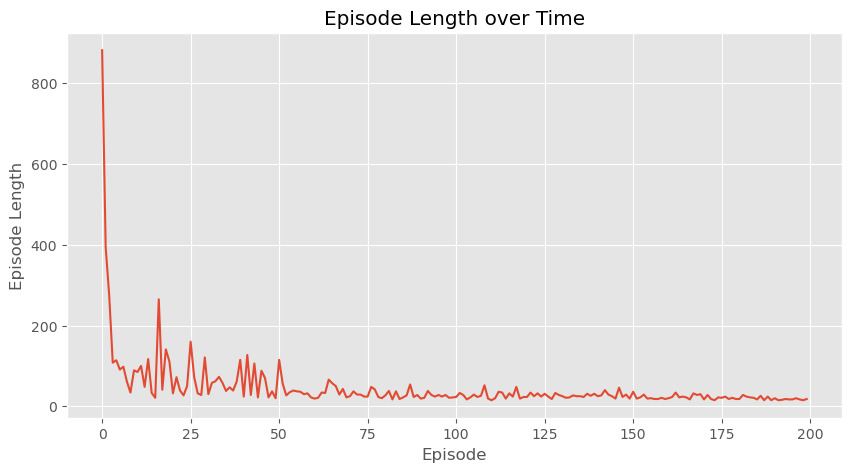

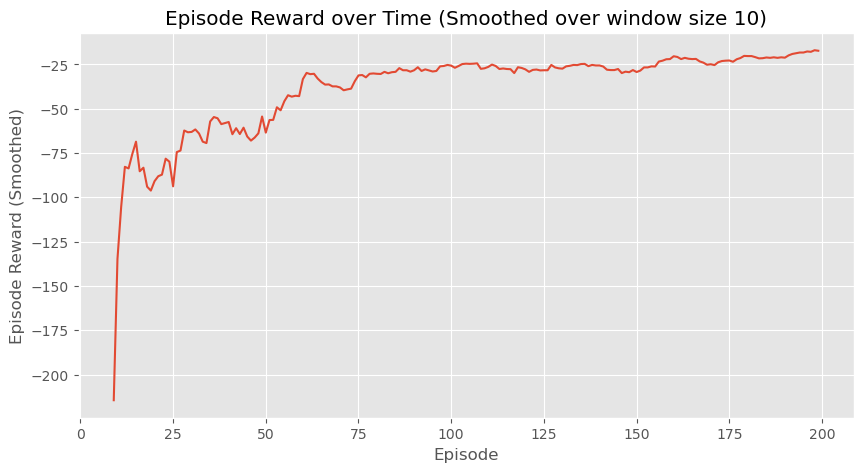

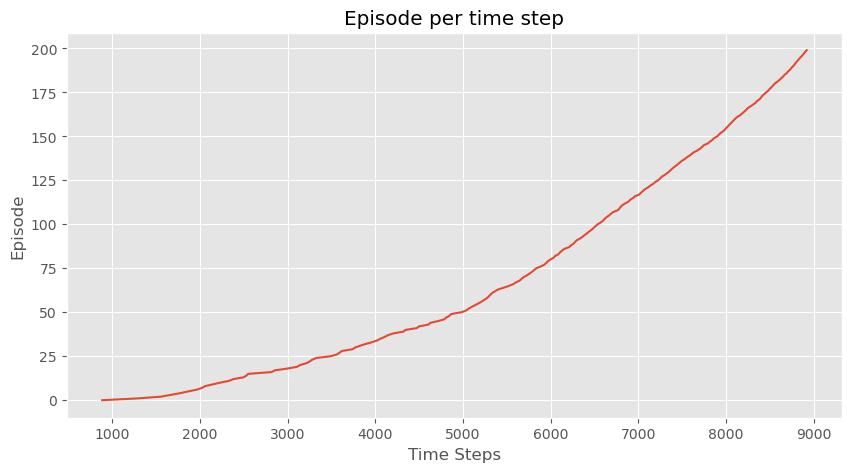

(<Figure size 1000x500 with 1 Axes>,
 <Figure size 1000x500 with 1 Axes>,
 <Figure size 1000x500 with 1 Axes>)

In [6]:
plotting.plot_episode_stats(stats)

## doing it for 500,000 episodes:


In [24]:
Q, stats = sarsa(env, 600000)

Episode 600000/600000. Number of steps to end episode is 18::

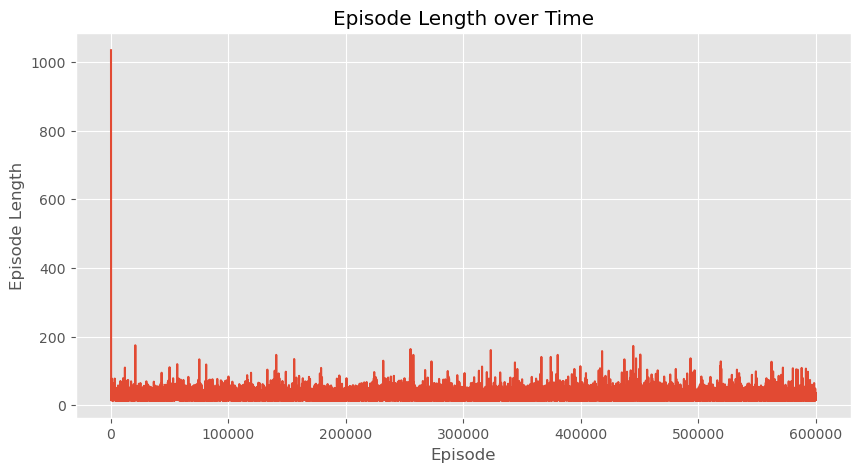

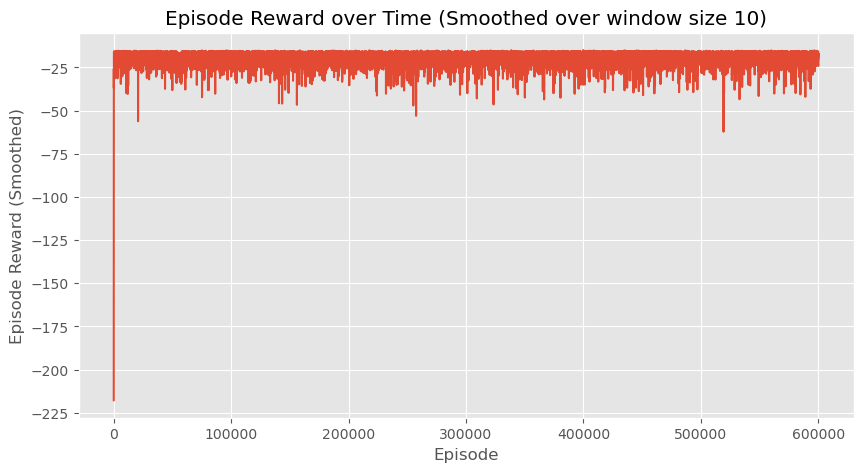

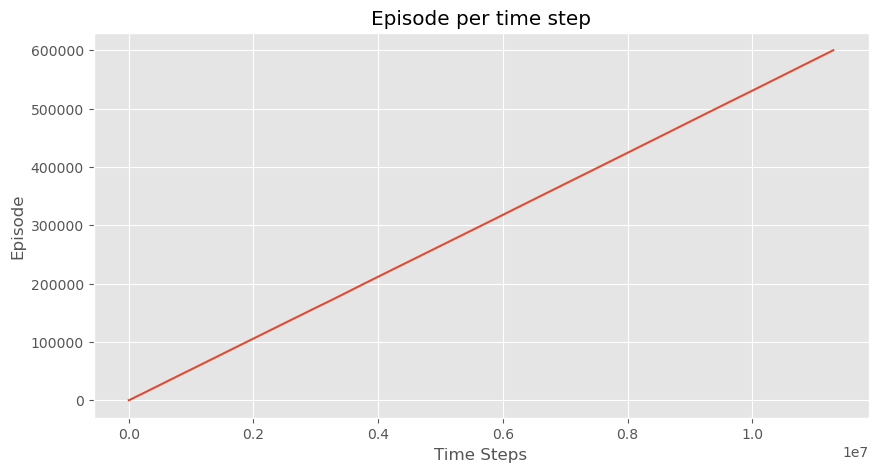

(<Figure size 1000x500 with 1 Axes>,
 <Figure size 1000x500 with 1 Axes>,
 <Figure size 1000x500 with 1 Axes>)

In [25]:
plotting.plot_episode_stats(stats)

## now try the offline policy result:

# It always take 15 steps to complete

In [26]:
def always_act_best( Q, nA):
    """
    give a Q function, return a state to action that always acts by maximizing.
    Assumption required:
    for every state, Q[state] is of length nA  
    
    """

    def policy_fn(observation):
        best_action = np.argmax(Q[observation])
        return best_action
    return policy_fn




starting running....
Episode 10000/10000. Number of steps to end episode is 15:

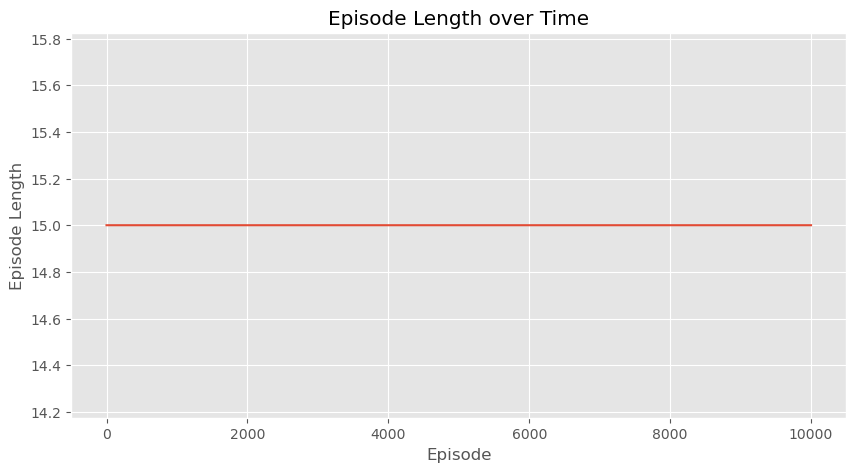

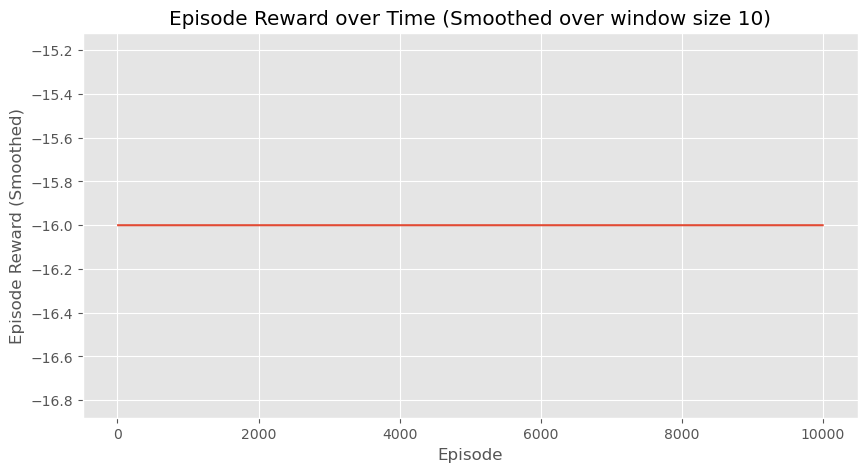

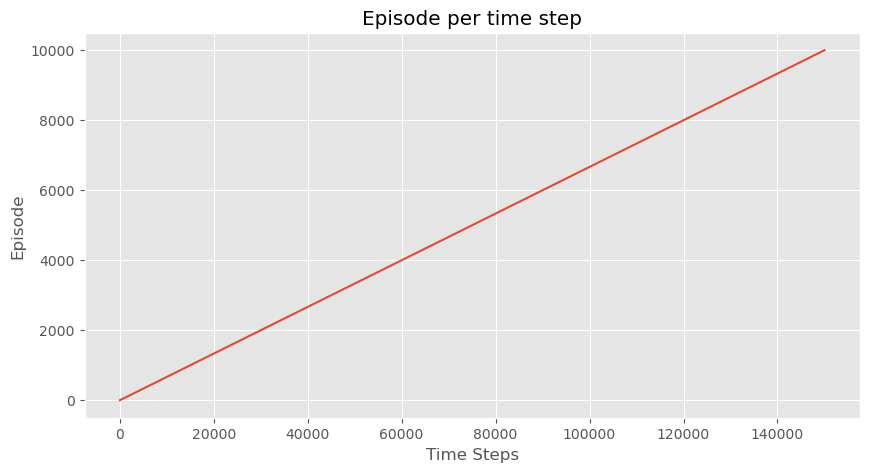

(<Figure size 1000x500 with 1 Axes>,
 <Figure size 1000x500 with 1 Axes>,
 <Figure size 1000x500 with 1 Axes>)

In [27]:

num_of_epi_to_try = 10000

# keep track of all results:

stats_act_best = plotting.EpisodeStats(
    episode_lengths= np.zeros(num_of_epi_to_try),
    episode_rewards= np.zeros(num_of_epi_to_try)
    )

# need to run one of the above training first:
best_policy = always_act_best(Q, env.action_space.n)

print('starting running....')

for epi in range(num_of_epi_to_try):


    state = env.reset()
    for t in itertools.count():
        action = best_policy(state)
        next_state, reward, done, _ = env.step(action)
        
        #update statistics:
        stats_act_best.episode_rewards[epi] += reward
        stats_act_best.episode_lengths[epi] =t
        state = next_state
        if done:
            break

    print("\rEpisode {}/{}. Number of steps to end episode is {}:".format(epi + 1, num_of_epi_to_try, t), end="")

    print("\rEpisode {}/{}.".format(epi+ 1, num_of_epi_to_try), end="")
    sys.stdout.flush()

plotting.plot_episode_stats(stats_act_best)



In [28]:
env.nS

70

In [29]:
Q[16]

array([-12.92127596, -10.17895728, -13.0301478 , -12.91398159])

# now, time to try with only one episode, see how the 'act-best' agent will do.



In [30]:

state = env.reset()
env.render()
cum_reward = 0
# acting until the end of one episode:
while True:
    action = best_policy(state)
    next_state, reward, done, _ = env.step(action)
    cum_reward += reward
    state = next_state
    env.render()
    if done:
        print('The end of episode. Total reward is', cum_reward)
        break

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o